In [28]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [29]:
df = pd.read_csv('features.csv')

In [30]:
X = df.drop('label', axis=1)
y = df['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [34]:
xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [36]:
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print(f"Best XGBoost Params: {grid_search.best_params_}")


Best XGBoost Params: {'learning_rate': 0.3, 'max_depth': 8}


In [37]:
lr_preds = lr_model.predict(X_test_scaled)
xgb_preds = best_xgb.predict(X_test)

In [38]:
print("Logistic Regression Performance:")
print(classification_report(y_test, lr_preds))

print("XGBoost Performance:")
print(classification_report(y_test, xgb_preds))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89     30000
           1       0.87      0.92      0.89     30000

    accuracy                           0.89     60000
   macro avg       0.89      0.89      0.89     60000
weighted avg       0.89      0.89      0.89     60000

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     30000
           1       0.94      0.93      0.94     30000

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



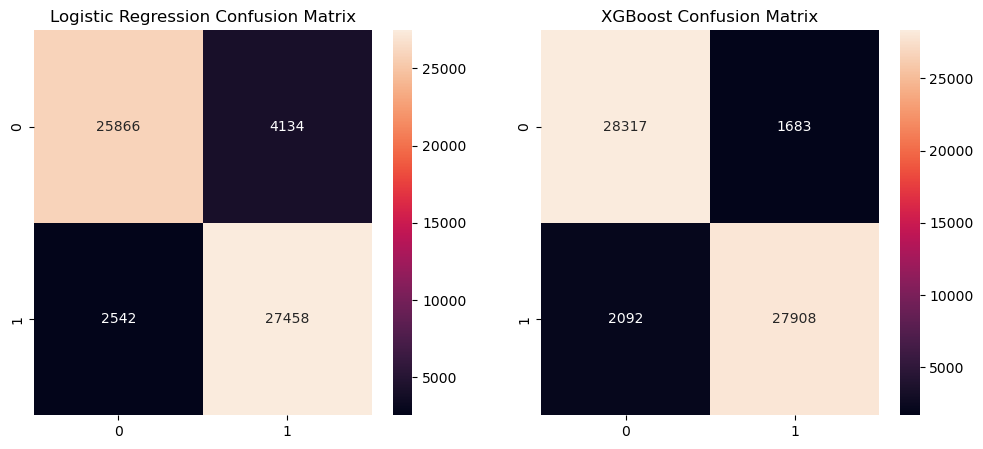

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt='d', ax=ax1)
ax1.set_title('Logistic Regression Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', ax=ax2)
ax2.set_title('XGBoost Confusion Matrix')
plt.show()

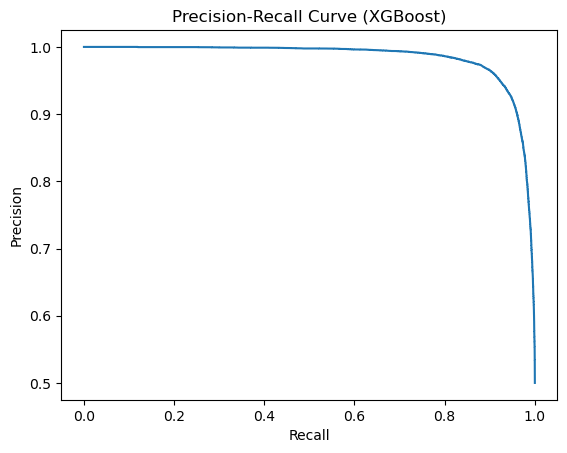

In [40]:
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.show()

In [41]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
                   feature  importance
6      num_external_links    0.577338
5  has_suspicious_keyword    0.094698
2               has_https    0.086916
1          num_subdomains    0.066836
0              url_length    0.058632
3             num_hyphens    0.049583
7             num_scripts    0.033128
4       num_special_chars    0.032868


In [42]:
# Adjust threshold for higher Recall if needed
threshold = 0.3  
xgb_preds_adjusted = (xgb_probs >= threshold).astype(int)
print("XGBoost Performance (Adjusted Threshold):")
print(classification_report(y_test, xgb_preds_adjusted))

XGBoost Performance (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     30000
           1       0.91      0.96      0.93     30000

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000

